<a href="https://colab.research.google.com/github/munich-ml/BER_tail_fit/blob/main/BER_fit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setup
Required Python imports


In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [109]:
np.random.seed(22)

## Transmitter

#### Simulation constants

In [110]:
N = int(4e5)      # number of simulated bits
DR = 1e9          # data rate [bits/s]
UI = 1/DR         # unit interval [s]
RJ_SIGMA = 0.025  # simulated random jitter's sigma
PJ_FREQ = 3e5     # frequency of the periodic jitter
PJ_AMPL = 0.1     # periodic jitter amplitude [UI]

### RJ, DJ, TJ simulation

In [111]:
t = np.linspace(start=0, stop=(N-1)*UI, num=N)   # time vector
dj = PJ_AMPL * np.sin(2 * np.pi * PJ_FREQ * t)   # determistic jitter,  consists of PJ, only
rj = RJ_SIGMA * np.random.randn(N)               # random jitter
tj = rj + dj                                     # total jitter

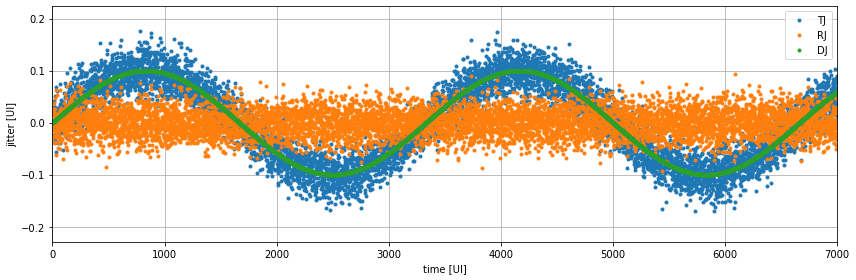

In [112]:
plt.figure(figsize=(12, 4))
plt.plot(tj, ".", label="TJ");
plt.plot(rj, ".", label="RJ");
plt.plot(dj, ".", label="DJ");
plt.xlabel("time [UI]"), plt.ylabel("jitter [UI]")
plt.xlim([0, 7000])
plt.legend(), plt.grid(), plt.tight_layout();

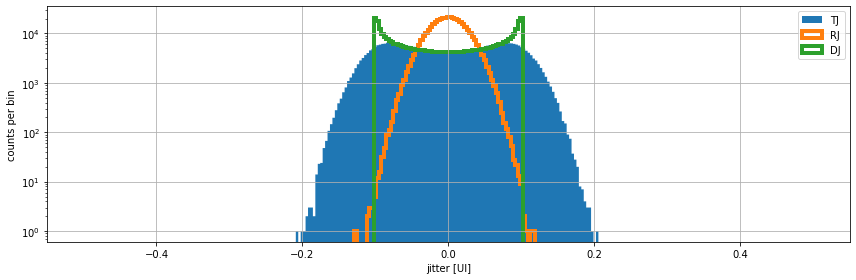

In [113]:
bins = np.linspace(-0.5, 0.5, 300)
plt.figure(figsize=(12, 4))
plt.hist(tj, bins=bins, histtype="stepfilled", label="TJ")
plt.hist(rj, bins=bins, histtype="step", linewidth=4, label="RJ")
plt.hist(dj, bins=bins, histtype="step", linewidth=4, label="DJ")
plt.yscale("log")
plt.ylabel("counts per bin"), plt.xlabel("jitter [UI]")
plt.legend(), plt.grid(), plt.tight_layout();

### Random bit sequence as data

In [114]:
data = np.random.randint(0, 2, N)

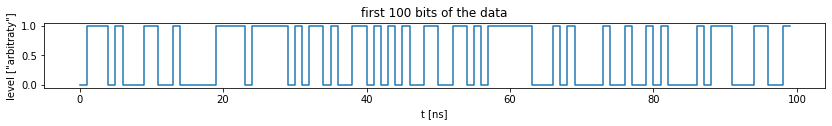

In [115]:
plt.figure(figsize=(14, 1.2))
n = 100
sns.lineplot(x=t[:n]*1e9, y=data[:n], drawstyle='steps-post')
plt.title(f"first {n} bits of the data")
plt.xlabel("t [ns]"), plt.ylabel('level ["arbitraty"]');

## Receiver

### Data sampling and error checking
Create a receiver sampler with `65` steps within the unit interval

In [116]:
RX_PI_STEPS = 65          # step count of the receiver phase interpolator
rx_pi = np.linspace(0, 1, num=RX_PI_STEPS)

Cheching for errors

In [117]:
errors = []
for rx_pi_step in rx_pi:
    errors.append(0)      # start with 0 errors at each new RX PI step
    for i, tj_sample in enumerate(tj):
        if 0 < i < N-1:                      # allows sampling data[i-1], data[i+1] 
            if tj_sample > rx_pi_step:         # checking left side eye
                errors[-1] += int(np.logical_xor(data[i-1], data[i]))
            if 1 + tj_sample < rx_pi_step:         # checking left side eye
                errors[-1] += int(np.logical_xor(data[i+1], data[i]))

### Compute and plot BER

In [118]:
ber = np.array(errors) / N

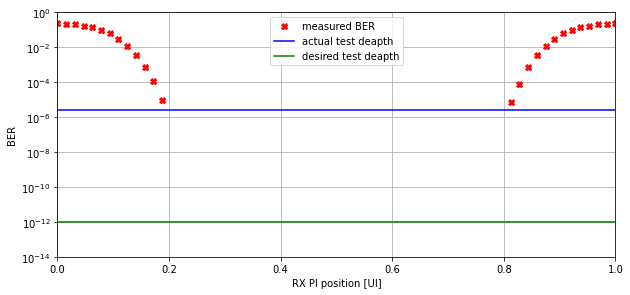

In [119]:
plt.figure(figsize=(10, 4.5))
plt.semilogy(rx_pi, ber, "rX", label="measured BER")
plt.semilogy([0, 1], [1/N, 1/N], "-b", label="actual test deapth")
plt.semilogy([0, 1], [1e-12, 1e-12], "-g", label="desired test deapth")
plt.xlabel("RX PI position [UI]"), plt.ylabel("BER")
plt.xlim([0, 1]), plt.ylim([1e-14, 1])
plt.legend(), plt.grid();